In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from denoise_rmt import (
    ImgNoiseCorruptor,
    denoise_mppca,
    apply_foreground_masks,
    normalize_imgs_0_255,
    snr, psnr, ssim,
    average_snr, average_psnr, average_ssim
)

In [24]:
def plot_slices(slices, titles=None, cmap="gray", origin="lower"):
    """Function to display a row of image slices."""
    n_slices = len(slices)

    if titles is None:
        titles = [f"Slice {i+1}" for i in range(n_slices)]

    # Old: fig, axes = plt.subplots(1, n_slices, figsize=(3 * n_slices, 2 * n_slices))
    fig, axes = plt.subplots(1, n_slices, figsize=(3.5 * n_slices, 3.8))

    if len(slices) > 1:
        for i, slice_array in enumerate(slices):
            axes[i].imshow(slice_array, cmap=cmap, origin=origin, aspect="auto")
            axes[i].set_title(titles[i])
            axes[i].grid(False)
    else:
        axes.imshow(slices[0], cmap=cmap, origin=origin)
        axes.set_title(titles[0])
        axes.grid(False)

In [12]:
tumor_slice = np.load("sim_data/sample_tumor_img.npy")
tumor_slice.shape

(184, 132)

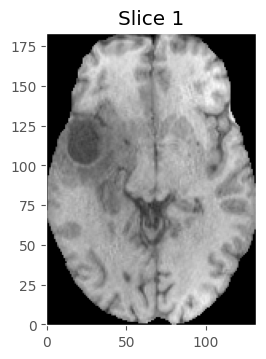

In [25]:
plot_slices([tumor_slice])

In [32]:
pad_tumor_slice = np.pad(tumor_slice, pad_width=5, mode="constant", constant_values=0)
pad_tumor_slice.shape

(194, 142)

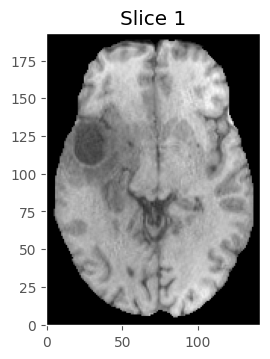

In [33]:
plot_slices([pad_tumor_slice])

In [28]:
# Number of measurements (snapshots)
n_snapshots = 100

# RNG seed
seed = 1

# Noise parameters
sigma = 35  # Marchenko-Pastur sigma ~ noise standard deviation
rice_b = 2  # Rice distribution parameter

# Denoising parameters
window_size = 16  # 16x16 MPPCA window size


In [34]:
noise_corruptor = ImgNoiseCorruptor(original_img=pad_tumor_slice)

In [35]:
snapshots, fg_masks = noise_corruptor.generate_rician_noisy_displaced_imgs(
    n_snapshots=n_snapshots,
    rice_b=rice_b,
    sigma=sigma,
    seed=seed,
)

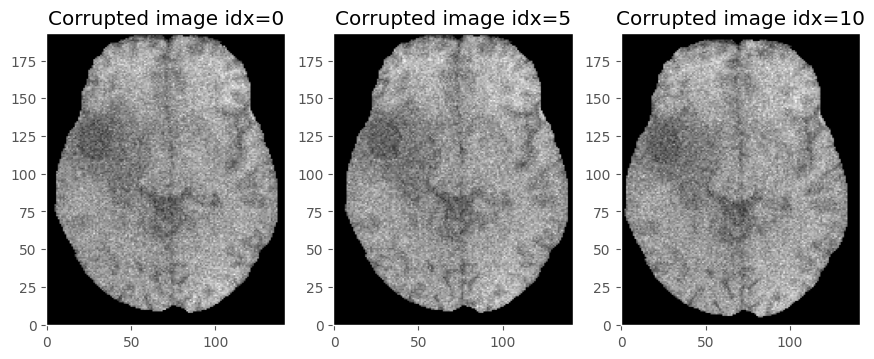

In [36]:
plot_slices(
    [snapshots[0], snapshots[5], snapshots[10]],
    titles=["Corrupted image idx=0", "Corrupted image idx=5", "Corrupted image idx=10"]
)

In [37]:
denoised_snapshots = denoise_mppca(snapshots, sigma=sigma, window_size=window_size)

Denoising 100 snapshots of size 194x142 (sigma = 35).


KeyboardInterrupt: 

In [ ]:
denoised_snapshots = apply_foreground_masks(snapshots=denoised_snapshots, fg_masks=fg_masks)
denoised_snapshots = normalize_imgs_0_255(snapshots=denoised_snapshots)

In [ ]:
plot_slices(
    slices=[denoised_snapshots[0], denoised_snapshots[5], denoised_snapshots[10]],
    titles=["Denoised image idx=0 using MPPCA", "Denoised image idx=5 using MPPCA", "Denoised image idx=10 using MPPCA"]
)

In [ ]:
original_mask = pad_tumor_slice > 0.0
den_mean_img = original_mask * np.mean(snapshots, axis=0)

plot_slices(
    [pad_tumor_slice, den_mean_img],
    titles=["Original", "Denoised snapshots by averaging"]
)

In [ ]:
den_ss_avg_snr = average_snr(ref_img=pad_tumor_slice, test_imgs=denoised_snapshots)
den_means_snr = snr(ref_img=pad_tumor_slice, test_img=den_mean_img)

print(f"Average SNR of snapshots using MPPCA: {den_ss_avg_snr}.")
print(f"SNR of image denoised by averaging: {den_means_snr}.")

In [ ]:
den_ss_avg_psnr = average_psnr(ref_img=pad_tumor_slice, test_imgs=denoised_snapshots)
den_means_psnr = psnr(ref_img=pad_tumor_slice, test_img=den_mean_img)

print(f"Average PSNR of snapshots using MPPCA: {den_ss_avg_psnr}.")
print(f"PSNR of image denoised by averaging: {den_means_psnr}.")

In [ ]:
den_ss_avg_ssim = average_ssim(ref_img=pad_tumor_slice, test_imgs=denoised_snapshots)
den_means_ssim = ssim(ref_img=pad_tumor_slice, test_img=den_mean_img)

print(f"Average SSIM of snapshots using MPPCA: {den_ss_avg_ssim}.")
print(f"SSIM of image denoised by averaging: {den_means_ssim}.")